## keras构建回归模型(Wide & Deep subclass implementation)

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf

from tensorflow import keras

print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

2.0.0-alpha0
sys.version_info(major=3, minor=6, micro=8, releaselevel='final', serial=0)
matplotlib 3.1.0
numpy 1.14.5
pandas 0.24.2
sklearn 0.21.2
tensorflow 2.0.0-alpha0
tensorflow.python.keras.api._v2.keras 2.2.4-tf


In [2]:
from sklearn.datasets import fetch_california_housing

housing = fetch_california_housing()
print(housing.DESCR)
print(housing.data.shape)
print(housing.target.shape)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block
        - HouseAge      median house age in block
        - AveRooms      average number of rooms
        - AveBedrms     average number of bedrooms
        - Population    block population
        - AveOccup      average house occupancy
        - Latitude      house block latitude
        - Longitude     house block longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
http://lib.stat.cmu.edu/datasets/

The target variable is the median house value for California districts.

This dataset was derived from the 1990 U.S. census, using one row per census
block group. A block group is the smallest geographical unit for which the U.S.
Census Bur

In [4]:
from sklearn.model_selection import train_test_split

# 默认划分比例为3:1
X_train_all, X_test, y_train_all, y_test = train_test_split(housing.data, housing.target,
                                                           random_state=7)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_all, y_train_all,
                                                     random_state=11)
print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)
print(X_test.shape, y_test.shape)

(11610, 8) (11610,)
(3870, 8) (3870,)
(5160, 8) (5160,)


In [5]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

### 使用子类API实现

In [7]:
# 继承keras.models.Model
class WideDeepModel(keras.models.Model):
    def __init__(self):
        # 先调用父类构造函数
        super(WideDeepModel, self).__init__()
        """定义模型的层次,然后可以以函数调用的方式来调用这些层次"""
        self._hidden1_layer = keras.layers.Dense(30, activation='relu')
        self._hidden2_layer = keras.layers.Dense(30, activation='relu')
        self._output_layer = keras.layers.Dense(1)
        
    def call(self, input):
        """完成模型的正向传播"""
        hidden1 = self._hidden1_layer(input)
        hidden2 = self._hidden2_layer(hidden1)
        concat = keras.layers.concatenate([input, hidden2])
        output = self._output_layer(concat)
        return output
    
# 定义模型对象
model = WideDeepModel()
# build用来指定模型输入的shape,相当于定义模型的输入层 model.add(keras.layers.Input(input_shape=[None, 8]))
model.build(input_shape=(None, 8))

model.summary()
model.compile(loss='mean_squared_error', optimizer='sgd')
callbacks = [keras.callbacks.EarlyStopping(patience=5, min_delta=1e-2)]

Model: "wide_deep_model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              multiple                  270       
_________________________________________________________________
dense_4 (Dense)              multiple                  930       
_________________________________________________________________
dense_5 (Dense)              multiple                  39        
Total params: 1,239
Trainable params: 1,239
Non-trainable params: 0
_________________________________________________________________


In [8]:
log_his = model.fit(X_train_scaled, y_train,
                   validation_data=(X_valid_scaled, y_valid),
                   epochs=100,
                   callbacks=callbacks)

Train on 11610 samples, validate on 3870 samples
Epoch 1/100
11610/11610 [==============================] - 0s 39us/sample - loss: 1.9281 - val_loss: 0.7929
Epoch 2/100
11610/11610 [==============================] - 0s 25us/sample - loss: 0.6802 - val_loss: 0.7039
Epoch 3/100
11610/11610 [==============================] - 0s 24us/sample - loss: 0.6324 - val_loss: 0.6647
Epoch 4/100
11610/11610 [==============================] - 0s 24us/sample - loss: 0.6033 - val_loss: 0.6364
Epoch 5/100
11610/11610 [==============================] - 0s 24us/sample - loss: 0.5800 - val_loss: 0.6132
Epoch 6/100
11610/11610 [==============================] - 0s 24us/sample - loss: 0.5607 - val_loss: 0.5932
Epoch 7/100
11610/11610 [==============================] - 0s 24us/sample - loss: 0.5453 - val_loss: 0.5784
Epoch 8/100
11610/11610 [==============================] - 0s 24us/sample - loss: 0.5328 - val_loss: 0.5637
Epoch 9/100
11610/11610 [==============================] - 0s 24us/sample - loss: 0.521

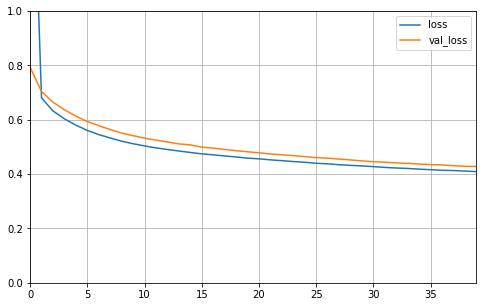

In [9]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.show()

plot_learning_curves(log_his)

In [10]:
model.evaluate(X_test_scaled, y_test)

5160/5160 [==============================] - 0s 12us/sample - loss: 0.4228


0.4227642719135728